In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas

from pts.model.deepar import DeepAREstimator
from pts import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
import json
from itertools import islice
from gluonts.dataset.field_names import FieldName
import numpy as np

/home/jan_rathfelder/env_one/lib/python3.7/site-packages/gluonts/json.py:46: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  "Using `json`-module for json-handling. "


In [2]:
# load df, select columns and set datetimeindex:

df = pd.read_csv('esp-xrlt.csv')
df['yyyymm'] = pd.to_datetime(df['yyyymm'])
df = df[0:30].copy()

cols = ['yyyymm', 'cei','amount']
df_used = df[cols]
df_used = df_used.set_index('yyyymm')
y = 'amount'

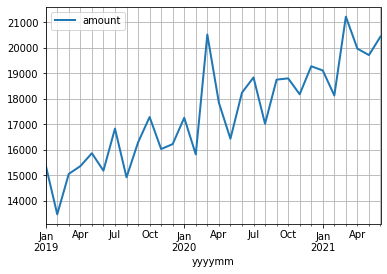

In [3]:
# plot data:

df_used[['amount']].plot(linewidth=2)
plt.grid(which='both')
plt.show()

### Training of simple time-series model

In [4]:
prediction_length = 6
train_time = max(df_used.index)-pd.offsets.Day(prediction_length)
train_time

Timestamp('2021-05-26 00:00:00')

In [5]:
# returns basic set of variables possible in Gluon-ts:

[f"FieldName.{k} = '{v}'" for k, v in FieldName.__dict__.items() if not k.startswith('_')]

["FieldName.ITEM_ID = 'item_id'",
 "FieldName.START = 'start'",
 "FieldName.TARGET = 'target'",
 "FieldName.FEAT_STATIC_CAT = 'feat_static_cat'",
 "FieldName.FEAT_STATIC_REAL = 'feat_static_real'",
 "FieldName.FEAT_DYNAMIC_CAT = 'feat_dynamic_cat'",
 "FieldName.FEAT_DYNAMIC_REAL = 'feat_dynamic_real'",
 "FieldName.PAST_FEAT_DYNAMIC_REAL = 'past_feat_dynamic_real'",
 "FieldName.FEAT_DYNAMIC_REAL_LEGACY = 'dynamic_feat'",
 "FieldName.FEAT_DYNAMIC = 'feat_dynamic'",
 "FieldName.PAST_FEAT_DYNAMIC = 'past_feat_dynamic'",
 "FieldName.FEAT_TIME = 'time_feat'",
 "FieldName.FEAT_CONST = 'feat_dynamic_const'",
 "FieldName.FEAT_AGE = 'feat_dynamic_age'",
 "FieldName.OBSERVED_VALUES = 'observed_values'",
 "FieldName.IS_PAD = 'is_pad'",
 "FieldName.FORECAST_START = 'forecast_start'",
 "FieldName.TARGET_DIM_INDICATOR = 'target_dimension_indicator'"]

In [6]:
# define target and features

target = np.array([df_used['amount']])
feat_static_real = np.array([df_used['cei']])
data_gluton = (target, feat_static_real)
data_gluton

(array([[15393.54245283, 13469.15550943, 15054.55662264, 15358.23315094,
         15865.31228302, 15181.22515094, 16829.69239623, 14921.4245283 ,
         16287.71624528, 17285.43650943, 16028.78998113, 16223.64130189,
         17256.63173585, 15818.62775472, 20519.91654717, 17847.57769811,
         16433.4440566 , 18239.79250943, 18837.91533962, 17020.553     ,
         18751.09467925, 18800.84637736, 18177.11681132, 19276.35190566,
         19111.09060377, 18130.25035849, 21221.76703774, 19965.57560377,
         19714.33713208, 20441.44367925]]),
 array([[0.02092962, 0.02217826, 0.02383749, 0.02034644, 0.02805849,
         0.02679568, 0.02722661, 0.01364447, 0.02558626, 0.03160065,
         0.03012255, 0.01908954, 0.02072608, 0.02310678, 0.01441896,
         0.01296704, 0.01495494, 0.01897017, 0.01502456, 0.00895671,
         0.01739007, 0.01905047, 0.02070831, 0.01462251, 0.01151698,
         0.01971061, 0.02346053, 0.02450893, 0.02329884, 0.02414243]]))

In [7]:
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields

freq='M'
start = df_used.index[0]

train_ds = ListDataset(
    [{'target': x, 'start': start} for x in target[:, :-prediction_length]],
    freq=freq
)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(
    [{'target': x, 'start': start} for x in target],
    freq=freq
)

In [8]:
# returns test and train dict

test_entry = next(iter(test_ds))
train_entry = next(iter(train_ds))

print(train_entry.keys(),
      test_entry.keys())


dict_keys(['target', 'start', 'source']) dict_keys(['target', 'start', 'source'])


/home/jan_rathfelder/env_one/lib/python3.7/site-packages/gluonts/dataset/common.py:323: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(string, freq=freq)
/home/jan_rathfelder/env_one/lib/python3.7/site-packages/gluonts/dataset/common.py:326: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if isinstance(timestamp.freq, Tick):
/home/jan_rathfelder/env_one/lib/python3.7/site-packages/gluonts/dataset/common.py:337: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return timestamp.freq.rollforward(timestamp)


In [9]:
# Inspect how train and test dict look:

print(train_entry)
print()
print(test_entry)

{'target': array([15393.542 , 13469.155 , 15054.557 , 15358.233 , 15865.3125,
       15181.226 , 16829.693 , 14921.425 , 16287.716 , 17285.436 ,
       16028.79  , 16223.642 , 17256.63  , 15818.628 , 20519.916 ,
       17847.578 , 16433.443 , 18239.793 , 18837.916 , 17020.553 ,
       18751.094 , 18800.846 , 18177.117 , 19276.352 ], dtype=float32), 'start': Timestamp('2019-01-31 00:00:00', freq='M'), 'source': SourceContext(source='list_data', row=0)}

{'target': array([15393.542 , 13469.155 , 15054.557 , 15358.233 , 15865.3125,
       15181.226 , 16829.693 , 14921.425 , 16287.716 , 17285.436 ,
       16028.79  , 16223.642 , 17256.63  , 15818.628 , 20519.916 ,
       17847.578 , 16433.443 , 18239.793 , 18837.916 , 17020.553 ,
       18751.094 , 18800.846 , 18177.117 , 19276.352 , 19111.09  ,
       18130.25  , 21221.768 , 19965.576 , 19714.338 , 20441.443 ],
      dtype=float32), 'start': Timestamp('2019-01-31 00:00:00', freq='M'), 'source': SourceContext(source='list_data', row=0)}


/home/jan_rathfelder/env_one/lib/python3.7/site-packages/gluonts/dataset/util.py:128: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  freq = start.freqstr


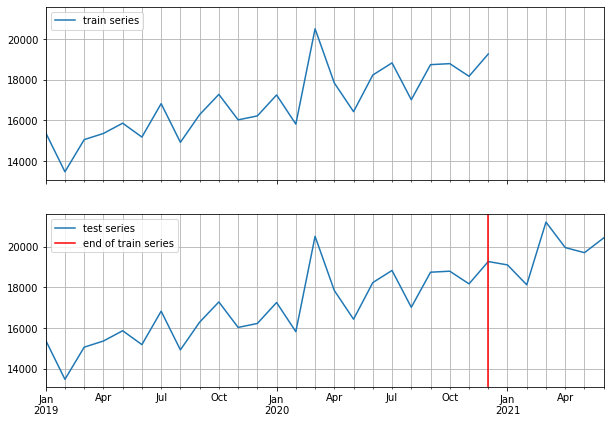

In [10]:
# plot train and testing data:

test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [11]:
# Train DeepAR model:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

estimator = DeepAREstimator(freq='M',
                            prediction_length=prediction_length,
                            input_size=12,
                            trainer=Trainer(epochs=10,
                                            learning_rate=1e-3,
                                            num_batches_per_epoch=128,
                                            batch_size=64,
                                            device=device))

predictor = estimator.train(training_data=train_ds, 
                            num_workers=0
                           )

  0%|          | 0/127 [00:00<?, ?it/s]

/home/jan_rathfelder/env_one/lib/python3.7/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/jan_rathfelder/env_one/lib/python3.7/site-packages/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq


  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

In [12]:
# make forecast and compare to observed values:

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=50,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

/home/jan_rathfelder/env_one/lib/python3.7/site-packages/gluonts/torch/batchify.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  data = torch.tensor(data, device=device)
Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  6.32it/s]
/home/jan_rathfelder/env_one/lib/python3.7/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq


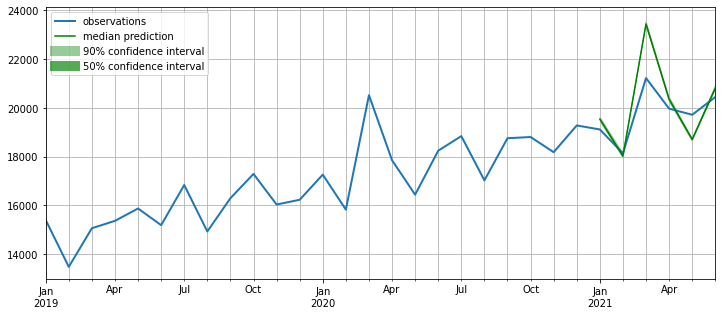

In [13]:
# plot forecast vs true:

def plot_forecasts(tss, forecasts, past_length, num_plots):
    for target, forecast in islice(zip(tss, forecasts), num_plots):
        ax = target[-past_length:].plot(figsize=(12, 5), linewidth=2)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        plt.show()

num_samples_used_for_ci = 100 # creates n predictions to generate intervall
forecast_it, ts_it = make_evaluation_predictions(test_ds, predictor=predictor, num_samples=num_samples_used_for_ci)
forecasts = list(forecast_it)
tss = list(ts_it)
plot_forecasts(tss, forecasts, past_length=150, num_plots=3)

In [14]:
# print errors:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 1066479.3333333333,
    "abs_error": 4523.59765625,
    "abs_target_sum": 118584.46875,
    "abs_target_mean": 19764.078125,
    "seasonal_error": 2423.4283854166665,
    "MASE": 0.3111018040579349,
    "MAPE": 0.03698566307624181,
    "sMAPE": 0.036258213222026825,
    "MSIS": 9.69847941615942,
    "QuantileLoss[0.1]": 5703.248046875,
    "Coverage[0.1]": 0.6666666666666666,
    "QuantileLoss[0.2]": 5541.24921875,
    "Coverage[0.2]": 0.6666666666666666,
    "QuantileLoss[0.3]": 5218.186328124999,
    "Coverage[0.3]": 0.6666666666666666,
    "QuantileLoss[0.4]": 4900.6171875,
    "Coverage[0.4]": 0.6666666666666666,
    "QuantileLoss[0.5]": 4523.59765625,
    "Coverage[0.5]": 0.6666666666666666,
    "QuantileLoss[0.6]": 4105.381249999999,
    "Coverage[0.6]": 0.6666666666666666,
    "QuantileLoss[0.7]": 3655.555859375,
    "Coverage[0.7]": 0.6666666666666666,
    "QuantileLoss[0.8]": 3111.84375,
    "Coverage[0.8]": 0.6666666666666666,
    "QuantileLoss[0.9]": 2551.347656

### Training multivariate time-series model:

In [399]:
# define target and features

target = np.array([df_used['amount']])
feat_dynamic_real = np.array([df_used['cei']])
data_gluton = (target, feat_static_real)

In [400]:
# define the parameters of the dataset
custom_ds_metadata = {
    'num_series': 1,
    'num_steps': len(data_gluton[0]),
    'prediction_length': 8,
    'freq': 'M',
    'start': [
        pd.Timestamp(df_used.index[0], freq='M')
        for _ in range(df_used.shape[0])
    ]
}

/home/jan_rathfelder/env_one/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  if __name__ == '__main__':


In [ ]:
# Define fields used
# Here we define a dynamic_real value on top of the target
train_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [fdr]
            #FieldName.FEAT_STATIC_CAT: [fsc]
        }
        for (target, start, fdr) in zip(
            target[:, :-custom_ds_metadata['prediction_length']],
            custom_ds_metadata['start'],
            feat_dynamic_real[:, :-custom_ds_metadata['prediction_length']]
            #feat_static_cat
        )
    ],
    freq=custom_ds_metadata['freq']
)

# test
test_ds = ListDataset(
    [
        {
            FieldName.TARGET: target,
            FieldName.START: start,
            FieldName.FEAT_DYNAMIC_REAL: [fdr]
            #FieldName.FEAT_STATIC_CAT: [fsc]
        }
        for (target, start, fdr) in zip(
            target,
            custom_ds_metadata['start'],
            feat_dynamic_real
            #feat_static_cat
            )
    ],
    freq=custom_ds_metadata['freq']
)

In [ ]:
# Returning train and test dict:

train_entry = next(iter(train_ds))
test_entry = next(iter(test_ds))

print(test_entry.keys(), train_entry.keys())

In [ ]:
# Return train dict:
# Note that we have added an array 
# for feat_dynamic_real as feature
# We need future values of this
# to make predictions (!)

test_entry

In [404]:
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    SetFieldIfNotPresent,
)

In [405]:
def create_transformation(freq, context_length, prediction_length):
    return Chain(
        [
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=prediction_length,
                log_scale=True,
            ),
            InstanceSplitter(
                target_field=FieldName.TARGET,
                is_pad_field=FieldName.IS_PAD,
                start_field=FieldName.START,
                forecast_start_field=FieldName.FORECAST_START,
                instance_sampler=ExpectedNumInstanceSampler(
                    num_instances=1,
                    min_future=prediction_length,
                ),
                past_length=context_length,
                future_length=prediction_length,
                time_series_fields=[
                    FieldName.FEAT_AGE,
                    FieldName.FEAT_DYNAMIC_REAL,
                    FieldName.OBSERVED_VALUES,
                ],
            ),
        ]
    )

In [414]:

transformation = create_transformation(
    custom_ds_metadata['freq'],
    2 * custom_ds_metadata['prediction_length'], # can be any appropriate value
    custom_ds_metadata['prediction_length']
)

In [415]:

train_tf = transformation(iter(train_ds), is_train=True)

print(type(train_tf))

<class 'generator'>


In [416]:
train_tf_entry = next(iter(train_tf))
[k for k in train_tf_entry.keys()]

/home/jan_rathfelder/env_one/lib/python3.7/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  return _shift_timestamp_helper(ts, ts.freq, offset)


['start',
 'source',
 'past_feat_dynamic_age',
 'future_feat_dynamic_age',
 'past_feat_dynamic_real',
 'future_feat_dynamic_real',
 'past_observed_values',
 'future_observed_values',
 'past_target',
 'future_target',
 'past_is_pad',
 'forecast_start']

In [417]:
train_tf_entry

{'start': Timestamp('2019-01-31 00:00:00', freq='M'),
 'source': SourceContext(source='list_data', row=0),
 'past_feat_dynamic_age': array([[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.30103   ],
        [0.47712123],
        [0.60206   ],
        [0.69897   ],
        [0.7781513 ]], dtype=float32),
 'future_feat_dynamic_age': array([[0.845098 ],
        [0.90309  ],
        [0.9542425],
        [1.       ],
        [1.0413927],
        [1.0791812],
        [1.1139433],
        [1.146128 ]], dtype=float32),
 'past_feat_dynamic_real': array([[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.02092962

In [418]:
test_tf = transformation(iter(test_ds), is_train=False)

In [419]:
test_tf_entry = next(iter(test_tf))
[k for k in test_tf_entry.keys()]

['start',
 'source',
 'past_feat_dynamic_age',
 'future_feat_dynamic_age',
 'past_feat_dynamic_real',
 'future_feat_dynamic_real',
 'past_observed_values',
 'future_observed_values',
 'past_target',
 'future_target',
 'past_is_pad',
 'forecast_start']

In [420]:
test_tf_entry

{'start': Timestamp('2019-01-31 00:00:00', freq='M'),
 'source': SourceContext(source='list_data', row=0),
 'past_feat_dynamic_age': array([[0.        ],
        [0.        ],
        [0.        ],
        [0.30103   ],
        [0.47712123],
        [0.60206   ],
        [0.69897   ],
        [0.7781513 ],
        [0.845098  ],
        [0.90309   ],
        [0.9542425 ],
        [1.        ],
        [1.0413927 ],
        [1.0791812 ],
        [1.1139433 ],
        [1.146128  ]], dtype=float32),
 'future_feat_dynamic_age': array([[1.1760913],
        [1.20412  ],
        [1.230449 ],
        [1.2552725],
        [1.2787536],
        [1.30103  ],
        [1.3222193],
        [1.3424227]], dtype=float32),
 'past_feat_dynamic_real': array([[0.        ],
        [0.        ],
        [0.        ],
        [0.02092962],
        [0.02217826],
        [0.0238375 ],
        [0.02034644],
        [0.02805849],
        [0.02679568],
        [0.02722661],
        [0.01364447],
        [0.02558626

In [422]:
print(f"past target shape: {train_tf_entry['past_target'].shape}")
print(f"future target shape: {train_tf_entry['future_target'].shape}")
print(f"past observed values shape: {train_tf_entry['past_observed_values'].shape}")
print(f"future observed values shape: {train_tf_entry['future_observed_values'].shape}")
print(f"past age feature shape: {train_tf_entry['past_feat_dynamic_age'].shape}")
print(f"future age feature shape: {train_tf_entry['future_feat_dynamic_age'].shape}")
#print(train_tf_entry['feat_static_cat'])

past target shape: (16,)
future target shape: (8,)
past observed values shape: (16,)
future observed values shape: (8,)
past age feature shape: (16, 1)
future age feature shape: (8, 1)


In [426]:
print(f"past target shape: {test_tf_entry['past_target'].shape}")
print(f"future target shape: {test_tf_entry['future_target'].shape}")
print(f"past observed values shape: {test_tf_entry['past_observed_values'].shape}")
print(f"future observed values shape: {test_tf_entry['future_observed_values'].shape}")
print(f"past age feature shape: {test_tf_entry['past_feat_dynamic_age'].shape}")
print(f"future age feature shape: {test_tf_entry['future_feat_dynamic_age'].shape}")
#print(test_tf_entry['feat_static_cat'])

past target shape: (16,)
future target shape: (8,)
past observed values shape: (16,)
future observed values shape: (8,)
past age feature shape: (16, 1)
future age feature shape: (8, 1)


In [429]:
# Train model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

estimator = DeepAREstimator(freq=custom_ds_metadata['freq'],
                            prediction_length=custom_ds_metadata['prediction_length'],
                            input_size=12,
                            trainer=Trainer(epochs=10,
                                            learning_rate=1e-3,
                                            num_batches_per_epoch=128,
                                            #feat_dynamic_real=False,
                                            #feat_dynamic_age=False,
                                            #past_feat_dynamic_age=False,
                                            batch_size=64,
                                            device=device))

predictor = estimator.train(training_data=train_ds, 
                                          num_workers=0
                           )

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

  0%|          | 0/127 [00:00<?, ?it/s]

In [430]:
# Return forcast and compare with true values:

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  6.31it/s]/home/jan_rathfelder/env_one/lib/python3.7/site-packages/gluonts/evaluation/_base.py:305: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  date_before_forecast = forecast.index[0] - forecast.index[0].freq



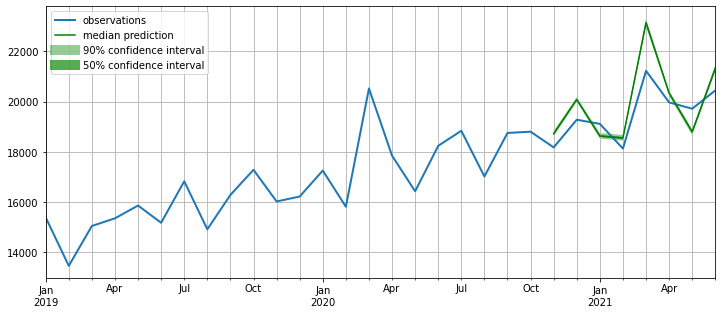

In [431]:
# Compare forecast vs true

def plot_forecasts(tss, forecasts, past_length, num_plots):
    for target, forecast in islice(zip(tss, forecasts), num_plots):
        ax = target[-past_length:].plot(figsize=(12, 5), linewidth=2)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        plt.show()

forecast_it, ts_it = make_evaluation_predictions(test_ds, predictor=predictor, num_samples=100)
forecasts = list(forecast_it)
tss = list(ts_it)
plot_forecasts(tss, forecasts, past_length=150, num_plots=3)

In [432]:
# Print errors:

print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 849504.875,
    "abs_error": 6369.58203125,
    "abs_target_sum": 156037.9375,
    "abs_target_mean": 19504.7421875,
    "seasonal_error": 2388.01015625,
    "MASE": 0.3334147268270229,
    "MAPE": 0.040039755403995514,
    "sMAPE": 0.039403147995471954,
    "MSIS": 10.91122708400332,
    "QuantileLoss[0.1]": 8166.475390625,
    "Coverage[0.1]": 0.75,
    "QuantileLoss[0.2]": 7927.73046875,
    "Coverage[0.2]": 0.75,
    "QuantileLoss[0.3]": 7483.608984375001,
    "Coverage[0.3]": 0.75,
    "QuantileLoss[0.4]": 6955.9984375,
    "Coverage[0.4]": 0.75,
    "QuantileLoss[0.5]": 6369.58203125,
    "Coverage[0.5]": 0.75,
    "QuantileLoss[0.6]": 5692.375781250001,
    "Coverage[0.6]": 0.75,
    "QuantileLoss[0.7]": 4959.459765625001,
    "Coverage[0.7]": 0.75,
    "QuantileLoss[0.8]": 4175.3921875,
    "Coverage[0.8]": 0.75,
    "QuantileLoss[0.9]": 3298.725390625,
    "Coverage[0.9]": 0.75,
    "RMSE": 921.685887382464,
    "NRMSE": 0.04725445117511703,
    "ND": 0.0408207268